In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
global_rng = np.random.default_rng(42)

In [3]:
# # Data from pre-VSS experiment
# df = pd.read_csv('crowdingReadingAcuity_dec24_cleaned.csv').iloc[:,1:]
# df['crowding_L5_var'] = np.var(df[['crowding_L5_test', 'crowding_L5_retest']], axis=1)
# df['crowding_R5_var'] = np.var(df[['crowding_R5_test', 'crowding_R5_retest']], axis=1)

In [4]:
def construct_cov_mtx(var_x: float, var_y: float, rho: float) -> np.ndarray:
    cov_xy = rho * np.sqrt(var_x * var_y)
    return np.array([[var_x, cov_xy],
                     [cov_xy, var_y]])


def simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points, rng=global_rng):
    if rng is None:
        rng = np.random.default_rng()
    cov = construct_cov_mtx(var_x, var_y, rho)
    data = rng.multivariate_normal([mu_x, mu_y], cov, size=n_points)
    x, y = data[:, 0], data[:, 1]
    return x, y

def add_gaussian_noise(x, y, noise_var, m=0, rng=global_rng):
    if rng is None:
        rng = np.random.default_rng()
    sd = np.sqrt(noise_var * m)
    x_noisy = x + rng.normal(0, sd, size=x.shape)
    y_noisy = y + rng.normal(0, sd, size=y.shape)
    return x_noisy, y_noisy



In [5]:
def tls_regression(x_vals, y_vals):
    """Compute Total Least Squares (orthogonal) regression slope and intercept."""
    x_mean, y_mean = x_vals.mean(), y_vals.mean()
    Sxx = np.sum((x_vals - x_mean)**2)
    Syy = np.sum((y_vals - y_mean)**2)
    Sxy = np.sum((x_vals - x_mean)*(y_vals - y_mean))
    # TLS slope formula
    slope = (Syy - Sxx + np.sqrt((Sxx - Syy)**2 + 4*Sxy**2)) / (2*Sxy)
    intercept = y_mean - slope * x_mean
    return slope, intercept

In [6]:
def plot_scatter_with_tls(
    x, y,
    rho=None,                      # for annotation
    ax=None,
    xlim=(-0.3, 0.9),
    ylim=(2, 4),
    xtick_step=0.3,
    ytick_step=0.5,
    xlabel='Variable X',
    ylabel='Variable Y',
    point_size=90,
    alpha=0.6,
    line_n=200,
    line_label='TLS fit',
    annotate=True,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    slope, intercept = tls_regression(x, y)
    r_value, _ = pearsonr(x, y)

    ax.scatter(x, y, s=point_size, alpha=alpha)

    # Draw fitted line over the visible x-range
    x_line = np.linspace(xlim[0], xlim[1], line_n)
    ax.plot(x_line, slope * x_line + intercept, linewidth=2, label=line_label)

    if annotate:
        if rho is not None:
            ax.text(0.05, 0.97, rf'$\rho = {rho}$',
                    transform=ax.transAxes, va='top', fontsize=22, color='black')
        ax.text(0.05, 0.89, rf'$r = {r_value:.2f}$',
                transform=ax.transAxes, va='top', fontsize=22, color='red')

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)

    ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
    ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))
    ax.tick_params(axis='both', which='major', labelsize=22)

    return ax


In [7]:
def simulate_r_over_sweep(
    x_values,
    simulate_fn,          # function taking (rng) and returning (x, y)
    measure_fn,           # function taking (x, y, sweep_value, rng) and returning (x_meas, y_meas)
    n_traces=3,
    rng=global_rng
):
    if rng is None:
        rng = np.random.default_rng()

    x_values = np.asarray(x_values)
    results = np.empty((n_traces, x_values.size), dtype=float)

    for t in range(n_traces):
        for idx, val in enumerate(x_values):
            x, y = simulate_fn(val, rng)                 # “true” data
            x_noisy, y_noisy = measure_fn(x, y, val, rng)        # add noise
            r, _ = pearsonr(x_noisy, y_noisy)
            results[t, idx] = r

    return results


In [8]:
def plot_traces(
    x_values,
    results,
    rho,
    xlabel,
    ylabel="Pearson's r",
    true_r=0.6,
    xscale='log',
    figsize=(16, 3),
    yticks=(0, 0.6, 1),
    ylim=(-0.4, 1.1),
    xlim=None,
    ticksize=22
):
    plt.figure(figsize=figsize)

    for t in range(results.shape[0]):
        plt.plot(x_values, results[t])

    plt.axhline(true_r, color='black', ls='--', label='True R')
    plt.xlabel(xlabel, size=ticksize)
    plt.ylabel(ylabel, size=ticksize)

    plt.xticks(size=ticksize)
    plt.yticks(list(yticks), size=ticksize)

    if xscale is not None:
        plt.xscale(xscale)

    if xlim is not None:
        plt.xlim(*xlim)

    plt.ylim(*ylim)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.tick_params(axis='x', labelsize=ticksize)

    plt.text(0.02, 0.97, rf'$\rho = {rho}$',
             transform=ax.transAxes, va='top', fontsize=ticksize, color='black')

    plt.tight_layout()
    plt.show()


In [9]:
def average_repeats(x, y, n_repeats, noise_var, m=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    n_points = x.shape[0]
    x_rep = np.empty((n_repeats, n_points))
    y_rep = np.empty((n_repeats, n_points))

    for i in range(n_repeats):
        x_rep[i], y_rep[i] = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=rng)

    return x_rep.mean(axis=0), y_rep.mean(axis=0)


## SAMPLING

In [10]:
mu_x = 0.25
mu_y = 2.9
var_x = 0.025
var_y = 0.06
rho = 0.6

<Axes: xlabel='Variable X', ylabel='Variable Y'>

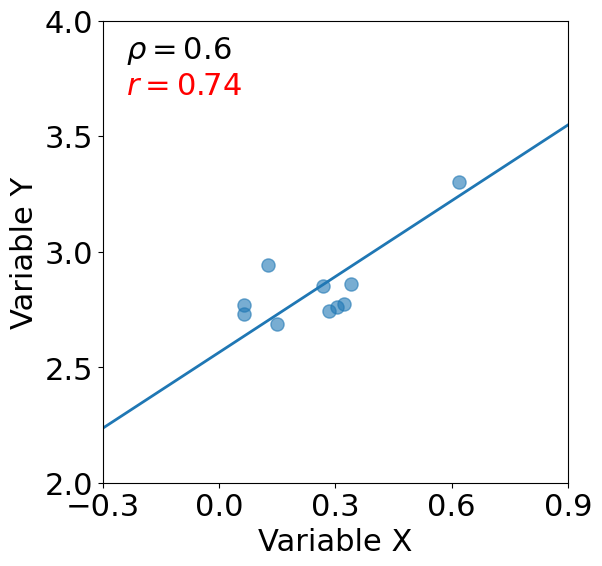

In [11]:
# 10 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=10)
plot_scatter_with_tls(x, y, rho=rho)

<Axes: xlabel='Variable X', ylabel='Variable Y'>

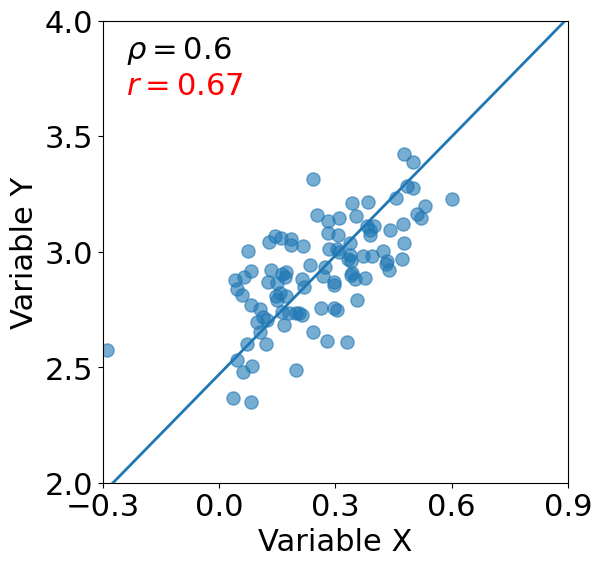

In [12]:
# 100 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100)
plot_scatter_with_tls(x, y, rho=rho)

<Axes: xlabel='Variable X', ylabel='Variable Y'>

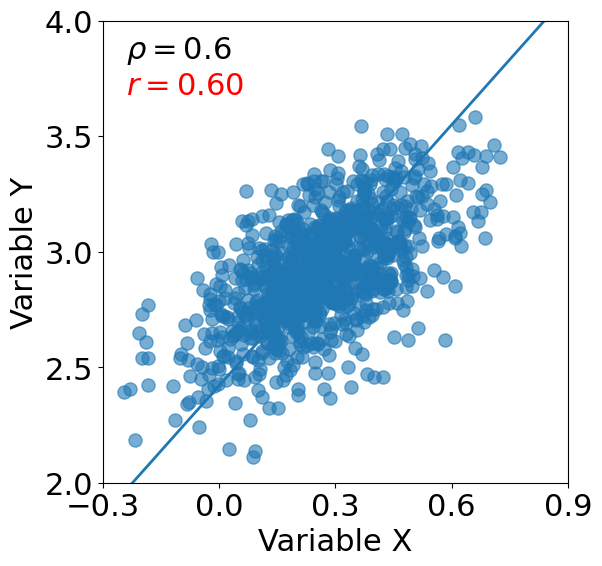

In [13]:
# 1000 points
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=1000)
plot_scatter_with_tls(x, y, rho=rho)

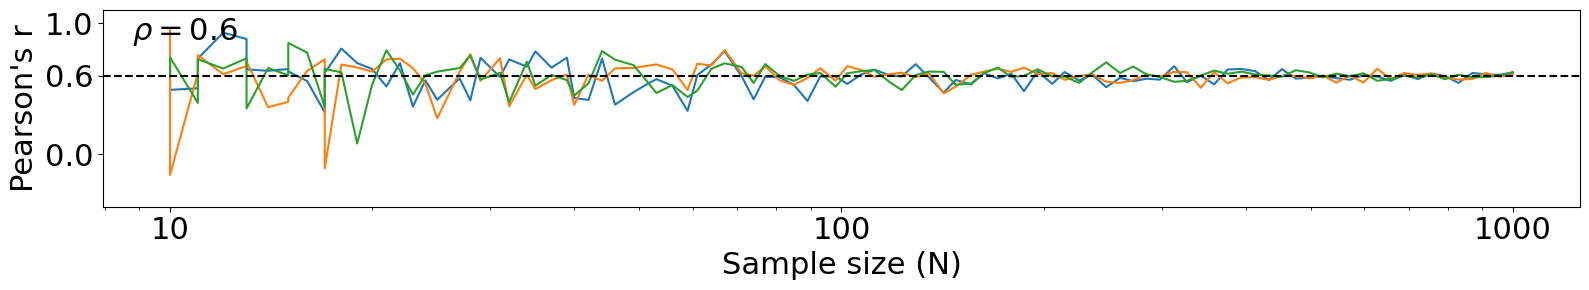

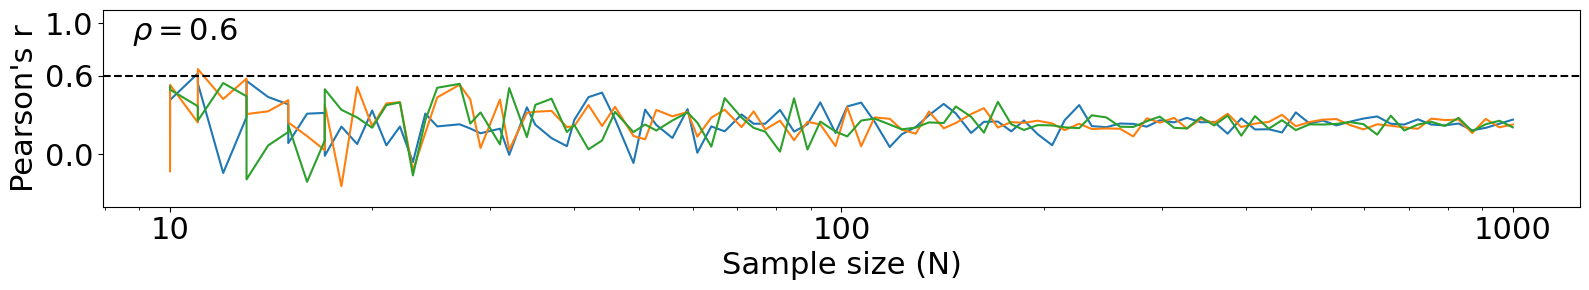

In [14]:
def simulate_fn(N, rng):
	# first, simulate "true" (noise-free) data
	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=int(N), rng=rng)

def measure_true(x, y, N, rng):
	# for the "true" measurement, just return the original data
	return x, y

def measure_noisy(x, y, N, rng):
	# add Gaussian noise to both x and y
	return add_gaussian_noise(x, y, noise_var=0.06, m=1.0, rng=rng)

sample_sizes=np.logspace(1, 3, num=100).round().astype(int)
results_true = simulate_r_over_sweep(sample_sizes, simulate_fn, measure_true)
plot_traces(sample_sizes, results_true, rho=rho, xlabel='Sample size (N)', ticksize=22)

results_noisy = simulate_r_over_sweep(sample_sizes, simulate_fn, measure_noisy)
plot_traces(sample_sizes, results_noisy, rho=rho, xlabel='Sample size (N)', ticksize=22)



## NOISE

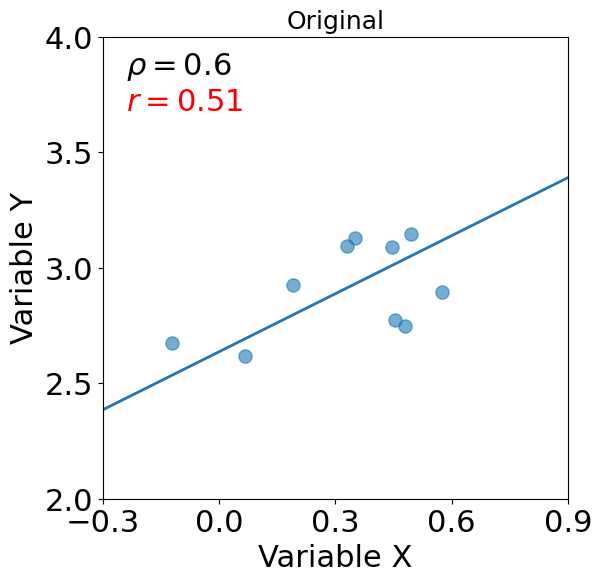

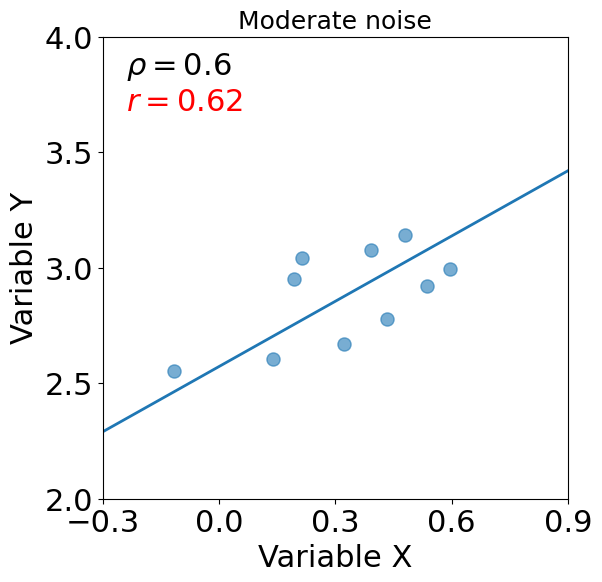

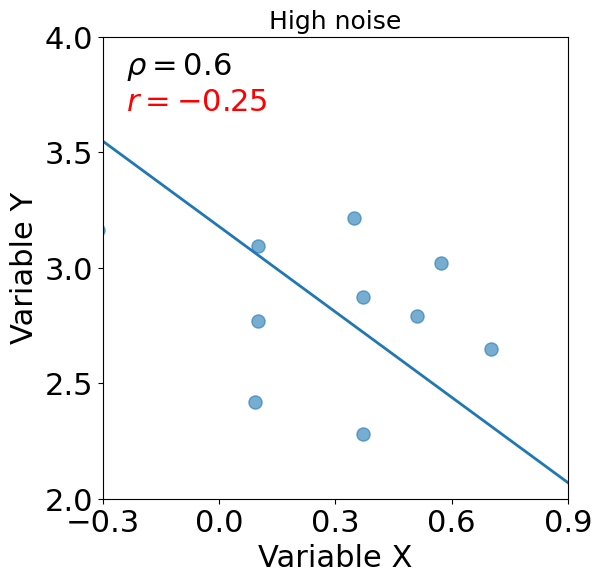

In [15]:
# Parameters
var_x, var_y, noise_var = 0.06, 0.06, 0.06

# Base data once
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=10, rng=global_rng)

# Plot: original + different noise multipliers
for m, title in [(0.0, 'Original'), (0.1, 'Moderate noise'), (1.0, 'High noise')]:
    if m == 0.0:
        x_plot, y_plot = x, y
    else:
        x_plot, y_plot = add_gaussian_noise(x, y, noise_var, m=m, rng=global_rng)

    ax = plot_scatter_with_tls(x_plot, y_plot, rho=rho)
    ax.set_title(title, fontsize=18)
    plt.show()

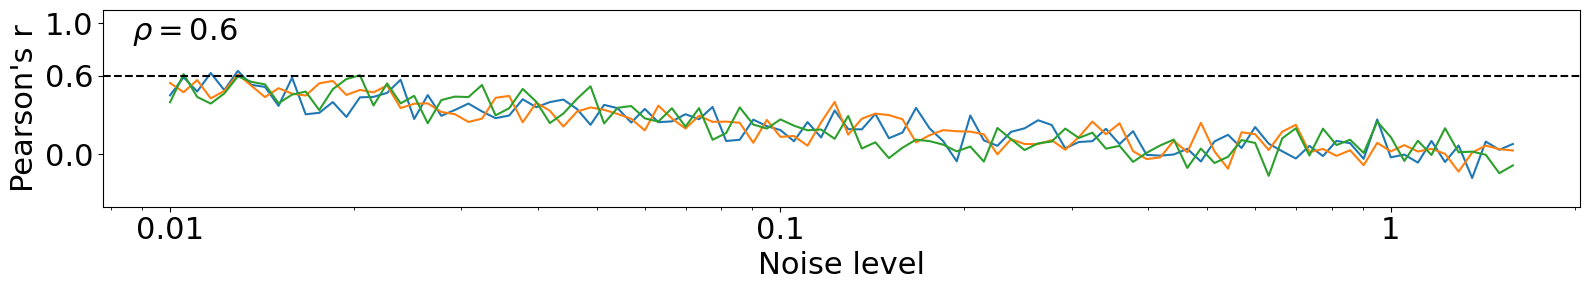

In [16]:
noise_levels = np.logspace(-2, 0.2, num=100)
def simulate_fn(noise_level, rng):
	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100, rng=rng)

def measure_fn(x, y, noise_level, rng):
	return add_gaussian_noise(x, y, noise_var=float(noise_level), m=1.0, rng=rng)

results = simulate_r_over_sweep(noise_levels, simulate_fn, measure_fn)
plot_traces(noise_levels, results, rho=rho, xlabel='Noise level', xscale='log', ticksize=22)


# MEANS

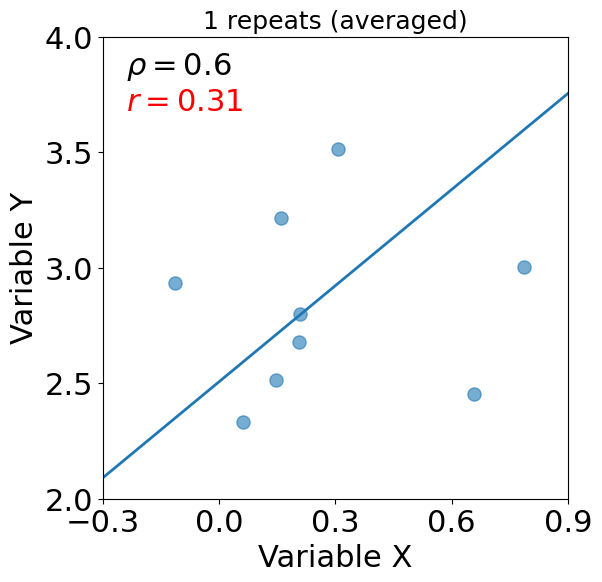

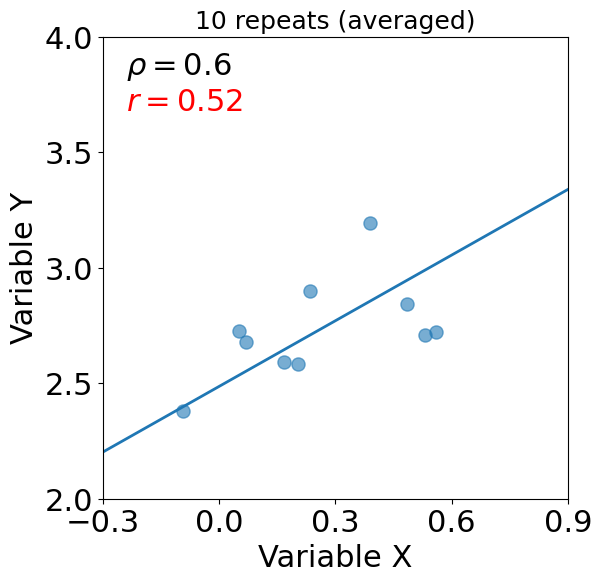

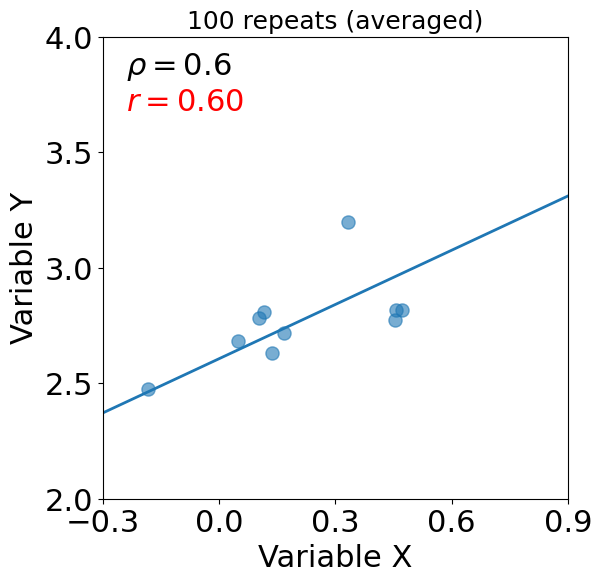

In [17]:
# Parameters
var_x, var_y, noise_var = 0.06, 0.06, 0.06
n_points = 10
m = 1.0

# Base data once
x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=global_rng)

# Plot: averaged over different numbers of repeats
for n_repeats in [1, 10, 100]:
    x_mean, y_mean = average_repeats(x, y, n_repeats=n_repeats, noise_var=noise_var, m=m, rng=global_rng)

    ax = plot_scatter_with_tls(x_mean, y_mean, rho=rho)
    ax.set_title(f'{n_repeats} repeats (averaged)', fontsize=18)
    plt.show()


In [36]:
def compute_noise_ceiling_splitHalf(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    even = measurements[0::2].mean(axis=0)   # repeats 0,2,4,...
    odd  = measurements[1::2].mean(axis=0)   # repeats 1,3,5,...
    r_i, _ = pearsonr(even, odd)
    # Spearman–Brown for 2 halves
    return (2 * r_i) / (1 + r_i)
    return r_m

def noise_ceiling_xy(x_reps, y_reps):
    rel_x = compute_noise_ceiling_splitHalf(x_reps)
    rel_y = compute_noise_ceiling_splitHalf(y_reps)
    return np.sqrt(rel_x * rel_y)


def plot_r_curves(xvals, curves, labels, styles, title=None, true_r=0.6):
    fig, ax = plt.subplots(figsize=(16, 3))

    for y, lab, st in zip(curves, labels, styles):
        ax.plot(xvals, y, **st, label=lab)

    ax.axhline(true_r, color='k', linestyle='--')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, true_r, 1])

    ax.set_xlabel('Number of thresholds', fontsize=22)
    ax.set_ylabel('r', fontsize=22)
    ax.tick_params(labelsize=22)

    if title is not None:
        ax.set_title(title, fontsize=22)

    if any(labels):
        ax.legend(loc='lower right', fontsize=16, frameon=False)

    plt.tight_layout()
    plt.show()


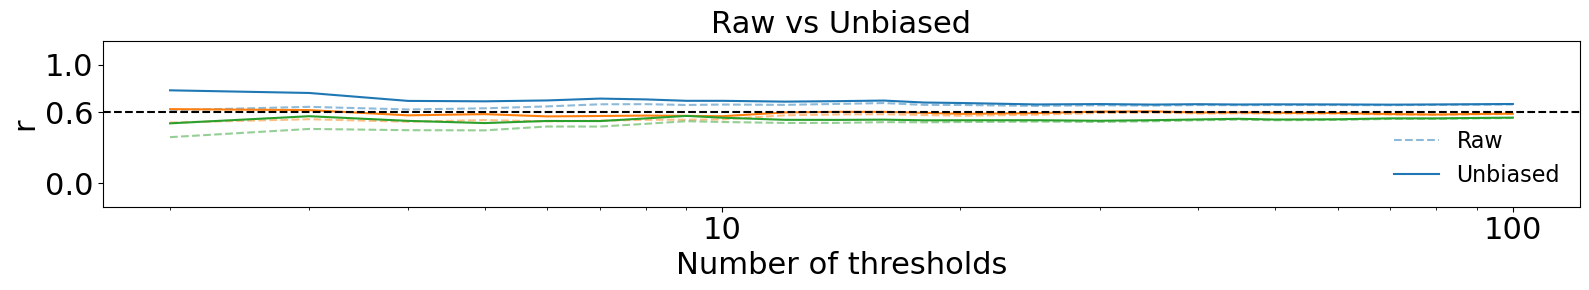

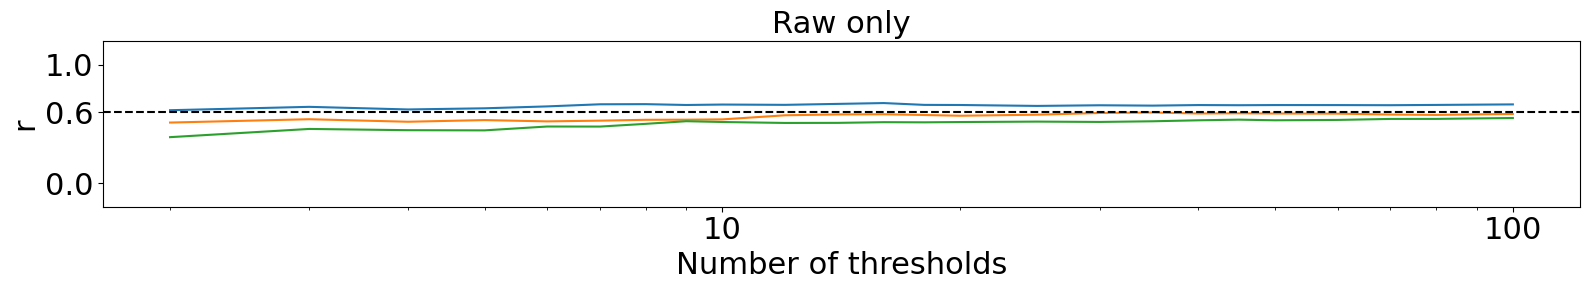

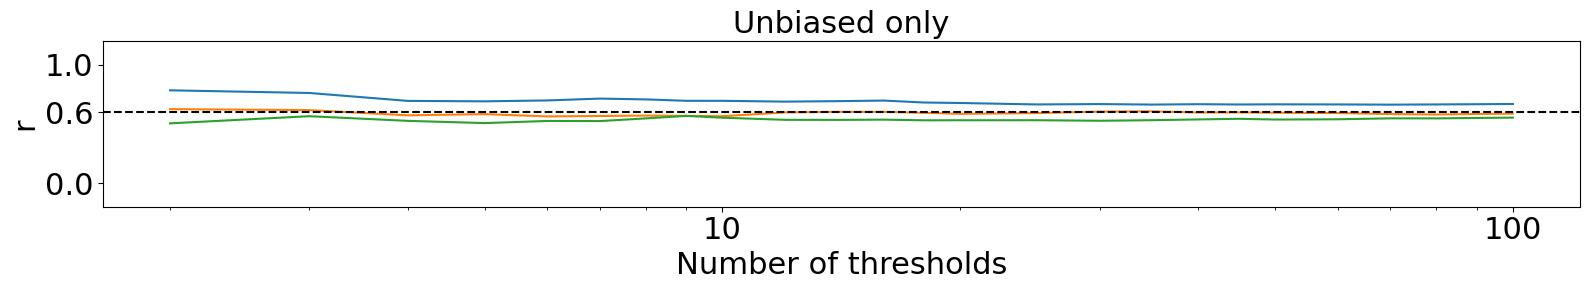

In [37]:
# --- parameters ---
mu_x, mu_y = 0.25, 2.9
var_x, var_y, noise_var = 0.0254, 0.0558, 0.02
rho = 0.6

# x values
num_thresholds = np.array([2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100])

n_traces = 3
max_T = int(num_thresholds.max())

# empty arrays to hold results
results_raw = np.empty((n_traces, num_thresholds.size))
results_unbiased = np.empty((n_traces, num_thresholds.size))

for t in range(n_traces):
	# underlying true x,y once per trace
	x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=global_rng)

	# preallocate all repeats
	x_reps = np.empty((max_T, n_points))
	y_reps = np.empty((max_T, n_points))

	# generate all repeats (then reuse prefixes)
	for k in range(max_T):
		x_reps[k], y_reps[k] = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=global_rng)

	# now sweep by taking first thresh repeats
	for idx, thresh in enumerate(num_thresholds):
		xs = x_reps[:thresh]
		ys = y_reps[:thresh]

		raw_r, _ = pearsonr(xs.mean(axis=0), ys.mean(axis=0))
		nc = noise_ceiling_xy(xs, ys)

		results_raw[t, idx] = raw_r
		results_unbiased[t, idx] = raw_r / nc

# --- plotting ---
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# combined plot (raw + unbiased per trace)
curves, labels, styles = [], [], []
for t in range(n_traces):
	c = colors[t % len(colors)]
	curves.append(results_raw[t])
	labels.append('Raw' if t == 0 else None)
	styles.append(dict(linestyle='--', color=c, alpha=0.5))

	curves.append(results_unbiased[t])
	labels.append('Unbiased' if t == 0 else None)
	styles.append(dict(linestyle='-', color=c, alpha=1.0))

plot_r_curves(num_thresholds, curves, labels, styles, title='Raw vs Unbiased', true_r=rho)

# raw-only
plot_r_curves(
	num_thresholds,
	[results_raw[t] for t in range(n_traces)],
	labels=[None]*n_traces,
	styles=[dict(linestyle='-', color=colors[t % len(colors)], alpha=1.0) for t in range(n_traces)],
	title='Raw only',
	true_r=rho
)

# unbiased-only
plot_r_curves(
	num_thresholds,
	[results_unbiased[t] for t in range(n_traces)],
	labels=[None]*n_traces,
	styles=[dict(linestyle='-', color=colors[t % len(colors)], alpha=1.0) for t in range(n_traces)],
	title='Unbiased only',
	true_r=rho
)


# ESTIMATOR SELECTION

In [24]:
import numpy as np

def choose_best_estimator(n_samples, n_meas, rho,
                          obs_var_x, meas_var_x,
                          obs_var_y, meas_var_y):
    """
    Decide whether raw or R-ceiling corrected Pearson r
    has lower RMSE, accounting for different variances in X and Y.

    Parameters
    ----------
    n_samples : int
        Number of observers (sample size).
    n_meas : int
        Number of repeated measurements per observer.
    rho : float
        True correlation (–1 to 1).
    obs_var_x : float
        Variance of true X thresholds across observers.
    meas_var_x : float
        Measurement noise variance for X.
    obs_var_y : float
        Variance of true Y thresholds across observers.
    meas_var_y : float
        Measurement noise variance for Y.

    Returns
    -------
    choice : str
        'raw' or 'r-ceiling'
    rmse_raw : float
    rmse_rceil : float
    """
    # reliability for X and Y
    Rx = obs_var_x / (obs_var_x + meas_var_x / n_meas)
    Ry = obs_var_y / (obs_var_y + meas_var_y / n_meas)
    lam = np.sqrt(Rx * Ry)

    # approximate sampling variance of Pearson r
    var_r = (1 - rho**2)**2 / (n_samples - 1)

    # approximate RMSEs
    rmse_raw = np.sqrt(var_r + (rho * (1 - lam))**2)
    rmse_rceil = np.sqrt(var_r / lam**2)

    choice = 'raw' if rmse_raw < rmse_rceil else 'r-ceiling'
    return choice, rmse_raw, rmse_rceil

In [25]:
choice, rmse_raw, rmse_rc = choose_best_estimator(
    n_samples=30,
    n_meas=2,
    rho=0.6,
    obs_var_x=0.0254,
    meas_var_x=0.0141*10,
    obs_var_y=0.056,
    meas_var_y=0.0157*10
)
print(f"Best estimator: {choice}")
print(f"RMSE raw = {rmse_raw:.3f}, RMSE r-ceiling = {rmse_rc:.3f}")

Best estimator: r-ceiling
RMSE raw = 0.418, RMSE r-ceiling = 0.358


# --------------------------------------------------------------------------
# ------------------------------- ARCHIVE -------------------------------
# --------------------------------------------------------------------------

# RELIABILITIES

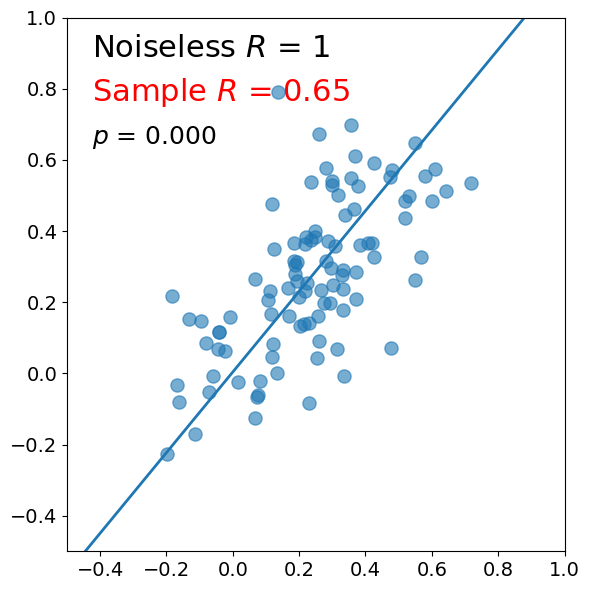

In [26]:
# Parameters: you can change these to your desired values
mu_x, mu_y = 0.25, 0.25
var_x, var_y = 0.025, 0.025
noise_std = np.sqrt(.014)
n_points = 100
rho = 1

# Construct covariance matrix
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])

# Draw samples
x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T

x_noisy = x + np.random.normal(0, noise_std, n_points)
y_noisy = y + np.random.normal(0, noise_std, n_points)
slope_n, intercept_n = tls_regression(x_noisy, y_noisy)
r_value, p_value = pearsonr(x_noisy, y_noisy)

plt.figure(figsize=(6, 6))
plt.scatter(x_noisy, y_noisy, s=90, alpha=0.6)
x_line_n = np.linspace(-3, 3, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2, label='TLS fit (noisy)')
plt.text(0.05, 0.97, f'Noiseless $R$ = 1',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'Sample $R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.text(0.05, 0.8, f'$p$ = {p_value:.3f}',
         transform=plt.gca().transAxes, va='top', fontsize=18, color='black')
plt.xlim(-.5, 1)
plt.ylim(-.5, 1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

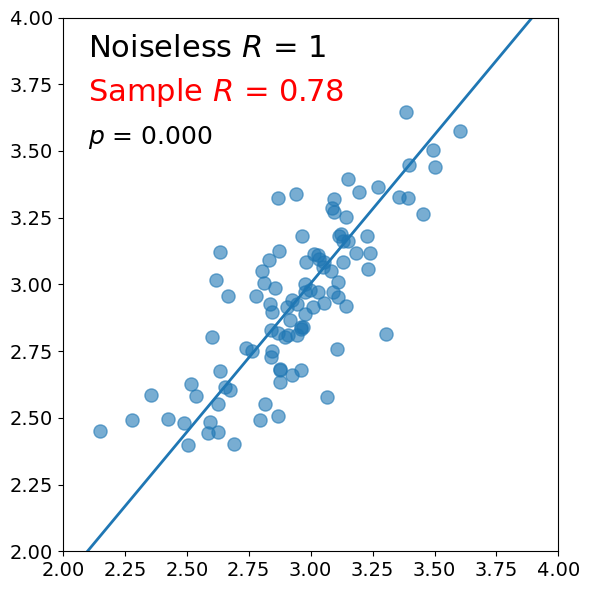

In [27]:
# Parameters
mu_x, mu_y = 2.9, 2.9
var_x, var_y = 0.06, 0.06
noise_std = np.sqrt(.016)
rho = 1

# Construct covariance matrix
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])

# Draw samples
x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T

x_noisy = x + np.random.normal(0, noise_std, n_points)
y_noisy = y + np.random.normal(0, noise_std, n_points)
slope_n, intercept_n = tls_regression(x_noisy, y_noisy)
r_value, p_value = pearsonr(x_noisy, y_noisy)

plt.figure(figsize=(6, 6))
plt.scatter(x_noisy, y_noisy, s=90, alpha=.6)
x_line_n = np.linspace(-3, 5, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2)
plt.text(0.05, 0.97, f'Noiseless $R$ = 1',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'Sample $R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.text(0.05, 0.8, f'$p$ = {p_value:.3f}',
         transform=plt.gca().transAxes, va='top', fontsize=18, color='black')
plt.xlim(2, 4)
plt.ylim(2, 4)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

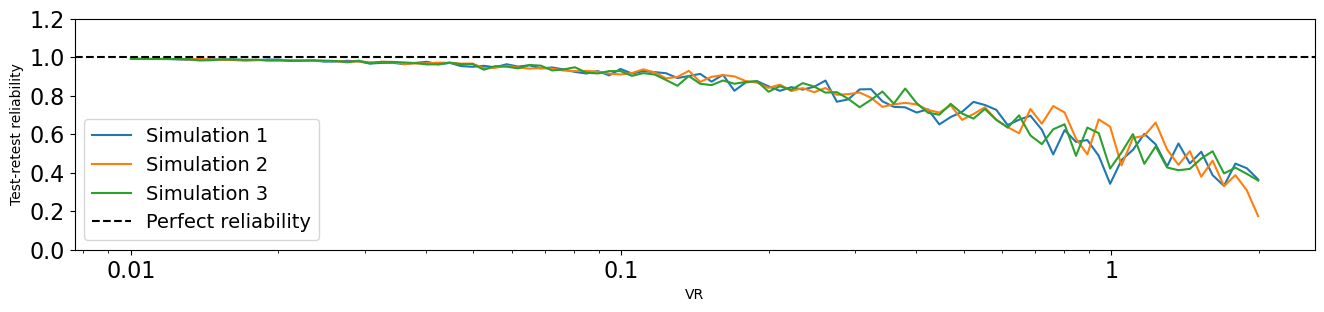

In [28]:
# Parameters
mu_x, mu_y = 2, 2
var_x, var_y = 1, 1
rho = 1
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])
N = 100
data = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=N)

# Define a range of noise levels
noise_levels = np.logspace(-2, 0.3, num=100)
n_traces = 3  # number of replicate traces

# Preallocate array to hold Pearson r values
results = np.empty((n_traces, noise_levels.size))

# Simulate and compute Pearson r for each trace and sample size
for t in range(n_traces):
    for idx, noise_var in enumerate(noise_levels):
        noise = np.random.normal(0, np.sqrt(noise_var), size=data.shape)
        noisy_data = data + noise
        r, _ = pearsonr(noisy_data[:, 0], noisy_data[:, 1])
        results[t, idx] = r

plt.figure(figsize=(16, 3))
for t in range(n_traces):
    plt.plot(noise_levels, results[t], label=f'Simulation {t+1}')
plt.axhline(1, color='black', ls='--', label = 'Perfect reliability')
plt.xlabel('VR')
plt.ylabel("Test-retest reliability")
plt.xticks(size=16)
plt.yticks(size=16)
#plt.xlim(0,100)
plt.ylim(0,1.2)
plt.xscale('log')
ax = plt.gca()
# Use %g so you get regular decimal notation (e.g. 0.1, 1, 10) instead of 1e-1, 1e0, 1e1
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

# And adjust tick label sizes
ax.tick_params(axis='x', labelsize=16)
plt.legend(fontsize=14)
plt.show()